<a href="https://colab.research.google.com/github/mohamed-yassine-benkhadda/Cloud_removal/blob/main/%20Cloud_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ Task 1 : Image segmentation

## In this task we will build a model able to detect the occurrences of cloud in the given images and generate a mask for these clouds ☁

### Import libraries 🧰

In [8]:
import os
import sys
from google.colab import drive
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.metrics import roc_curve, auc
from scipy import ndimage
from PIL import Image, ImageEnhance
import numpy as np
import cv2
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from numpy import vstack
import torch.nn as nn
from torch.optim import Adam, Adagrad
from torch.nn import BCELoss
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.optim import SGD
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
from skimage import filters
from skimage import exposure
import skimage
import matplotlib.pyplot as plt
import re
import random
import math
from datetime import datetime

### Download data from Kaggle ⬇
The data we will use for this task is provided by kaggle : 
https://www.kaggle.com/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images

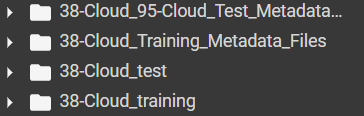

In [9]:
# Connect to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Locate the json file
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [11]:
# Download and unzip the dataset
!kaggle datasets download -d sorour/95cloud-cloud-segmentation-on-satellite-images --unzip

100% 14.2G/14.2G [01:02<00:00, 308MB/s]
100% 14.2G/14.2G [01:02<00:00, 242MB/s]


In [ ]:
# !rm -d 38-Cloud_95-Cloud_Test_Metadata_Files

### Define the dataset class 📪

In [12]:
# define random seed
random.seed(42)

In [ ]:
def _2ndvi(p1, p2):
    ndvi = np.zeros(p1.shape)
    for i in range(p1.shape[0]):
        for j in range(p1.shape[1]):
            if p1[i][j] == p2[i][j] and p2[i][j] == 0:
                ndvi[i,j] = 0
            else:
                ndvi[i,j] = (p1[i][j] - p2[i][j])/(p1[i][j] + p2[i][j])
    return ndvi

In [ ]:
a = np.random.rand(3,3)
a = torch.from_numpy(a)
b = np.random.rand(3,3)
b = torch.from_numpy(b)
(a ==b).sum().item()

0

In [55]:
class _Data(Dataset):
  def __init__(self, files):
      self.files = files
      self.images = []
      for f in files:
          pic_red = cv2.imread(str(f["red"]))[...,0]
          pic_green = cv2.imread(str(f["green"]))[...,1]
          pic_blue = cv2.imread(str(f["blue"]))[...,2]
          pic_gt = cv2.imread(str(f["gt"]))
          pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
          # pic_gt = np.rot90(np.fliplr(pic_gt))
#           pic_nir = cv2.imread(str(f["nir"]))
#           pic_nir = cv2.cvtColor(pic_nir, cv2.COLOR_BGR2GRAY)
          rgbArray = np.zeros((384,384,3), 'float32')
          rgbArray[..., 0] = pic_red
          del pic_red
          rgbArray[..., 1] = pic_green
          del pic_green
          rgbArray[..., 2] = pic_blue
          del pic_blue
          self.images.append((rgbArray * 0.95 + fix_contrast(rgbArray) * 0.05,pic_gt))
      print("Done ✅")
  def __getitem__(self,i):
      return self.images[i]

  def __len__(self):
      return len(self.images)   

In [14]:
# Dataset Class
class CloudDataset(Dataset):
    def __init__(self, r_dir, base_dir,train=True,pytorch=True):
        super().__init__()
        self.files = []
        for f in os.listdir(base_dir/r_dir):
            if train:
              pic_gt = cv2.imread(str(base_dir/"train_gt_additional_to38cloud"/f.replace("red","gt")))
              pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
              to_tensor = transforms.ToTensor()
              t1 = to_tensor(pic_gt)
              ratio = t1.sum().numpy()
              if ratio/384**2 >=0.2 and ratio/384**2<=0.5:
                  self.files.append({
                      "red" : base_dir/"train_red_additional_to38cloud"/f,
                      "green" : base_dir/"train_green_additional_to38cloud"/f.replace("red","green"),
                      "blue" : base_dir/"train_blue_additional_to38cloud"/f.replace("red","blue"),
                      "nir" : base_dir/"train_nir_additional_to38cloud"/f.replace("red","nir"),
                      "gt" : base_dir/"train_gt_additional_to38cloud"/f.replace("red","gt"),
                  })
            else:
              self.files.append({
                  "red" : base_dir/"train_red_additional_to38cloud"/f,
                  "green" : base_dir/"train_green_additional_to38cloud"/f.replace("red","green"),
                  "blue" : base_dir/"train_blue_additional_to38cloud"/f.replace("red","blue"),
                  "nir" : base_dir/"train_nir_additional_to38cloud"/f.replace("red","nir"),
                  "gt" : base_dir/"train_gt_additional_to38cloud"/f.replace("red","gt"),
              })
        
    def split_train_test(self, ratio = 0.7):
        self.shuffle()
        elements = len(self.files)
        files = self.files[:math.ceil(elements * 1)]
        middle = int(len(files) * ratio)
        self.train_files = files[:middle]
        self.test_files = files[middle:]         
        return self.train_files,self.test_files
                                       
    def __len__(self):
        return len(self.files)

    def __getitem__(self,i):
      pic_red = cv2.imread(str(self.files[i]["red"]))
      pic_red = cv2.cvtColor(pic_red, cv2.COLOR_BGR2GRAY)
      pic_green = cv2.imread(str(self.files[i]["green"]))
      pic_green = cv2.cvtColor(pic_green, cv2.COLOR_BGR2GRAY)
      pic_blue = cv2.imread(str(self.files[i]["blue"]))
      pic_blue = cv2.cvtColor(pic_blue, cv2.COLOR_BGR2GRAY)
      print("here : ", str(self.files[i]["gt"]))
      pic_gt = cv2.imread(str(self.files[i]["gt"]))
      pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
      pic_nir = cv2.imread(str(self.files[i]["nir"]))
      pic_nir = cv2.cvtColor(pic_nir, cv2.COLOR_BGR2GRAY)
      pic = (np.dstack((pic_green,pic_blue,pic_red))) .astype(np.uint8)
      return pic,pic_gt

    def shuffle(self):
        return random.shuffle(self.files)

In [16]:
!ls 

38-Cloud_95-Cloud_Test_Metadata_Files
95-Cloud_Training_Metadata_Files
95-cloud_training_only_additional_to38-cloud
bibtex.txt
drive
sample_data
training_patches_38-cloud_nonempty.csv


In [56]:
# Instantiate train and test data
# ../input/95cloud-cloud-segmentation-on-satellite-images/
base_train = Path('95-cloud_training_only_additional_to38-cloud')
data = CloudDataset(base_dir=base_train,r_dir='train_red_additional_to38cloud')

In [46]:
len(data)

NameError: ignored

In [57]:
# Shuffle data
data.shuffle()

In [58]:
# Split data
train_data, test_data = data.split_train_test(ratio = 0.85)

In [21]:
del data

In [59]:
train_data = _Data(train_data)
# test_data = _Data(test_data)

Done ✅


In [ ]:
 l = (train_data[5][1].reshape(384,384,1)).flatten()

In [81]:
def plot_image(x, train = True):
    tensor = torch.from_numpy(x[0])
    tensor = tensor.cuda()
    tensor2 = torch.from_numpy(x[1])
    tensor2 = tensor2.cuda()
    tensor_cv2 = tensor.reshape(384,384,3).cpu().detach().numpy()
    plt.figure(figsize=(10,10))
    lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()
    if train:
        out = unet(tensor)
        out_cv2 = out.reshape(384,384).cpu().detach().numpy()
        im = fix_contrast(out_cv2).reshape(384,384)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    else:
        fig, (ax1,ax4) = plt.subplots(1, 2)
    fig.set_figheight(30)
    fig.set_figwidth(30)
    ax1.axis('off')
    ax1.imshow(tensor_cv2[...,1])
    if train:
        ax2.axis('off')
        ax2.imshow(out_cv2)
        ax3.axis('off')
        ax3.imshow(im >= filters.threshold_otsu(im))
    ax4.axis('off')
    ax4.imshow(lab_cv2)
    plt.show()

In [ ]:
!pip install opencv-contrib-python

<Figure size 720x720 with 0 Axes>

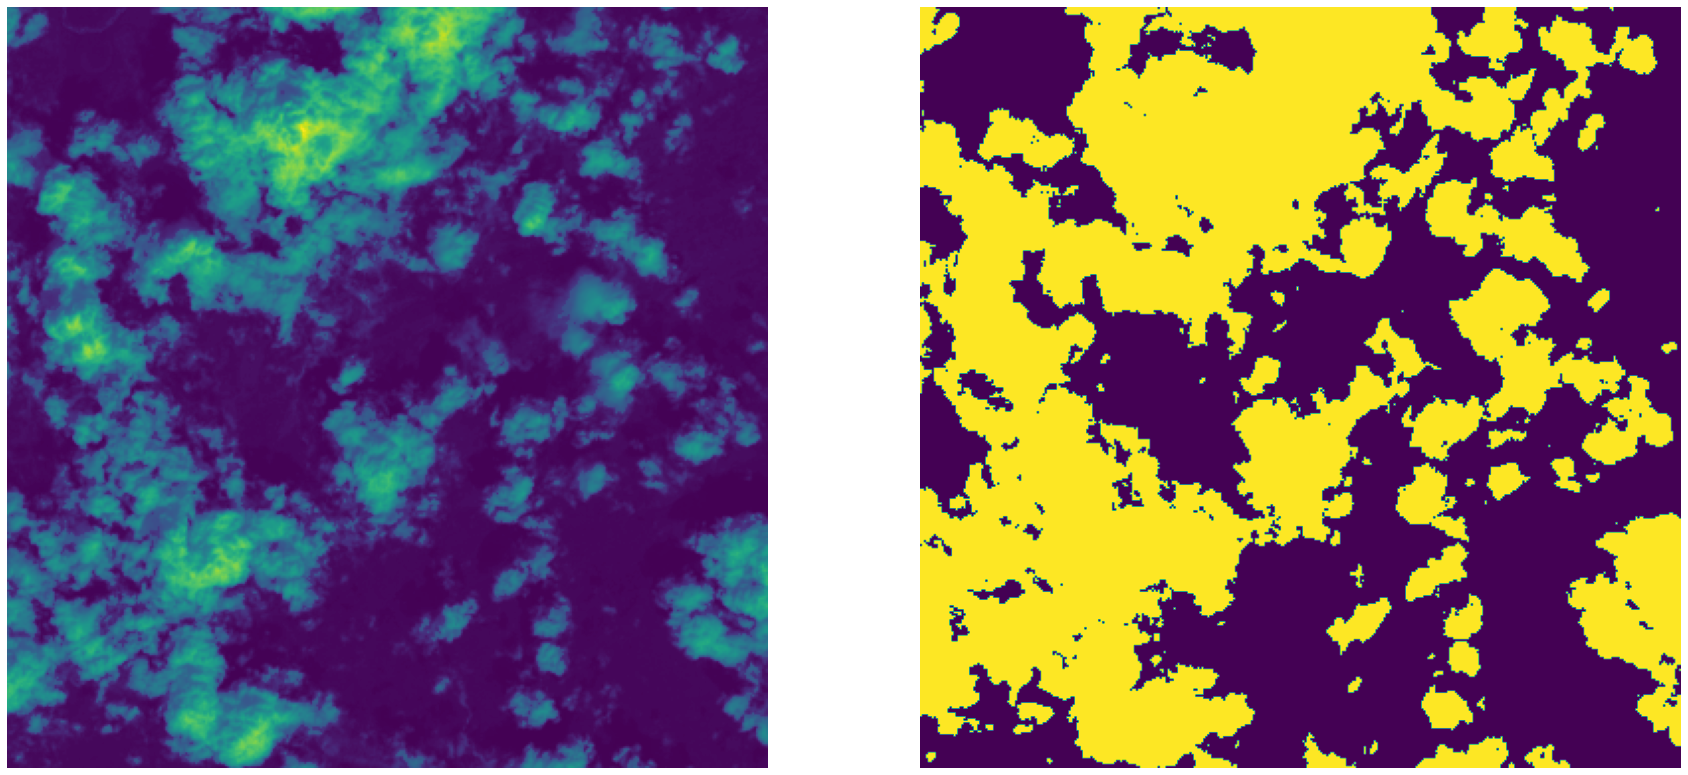

In [82]:
# from scipy.misc import toimage
plot_image(train_data[32], False)

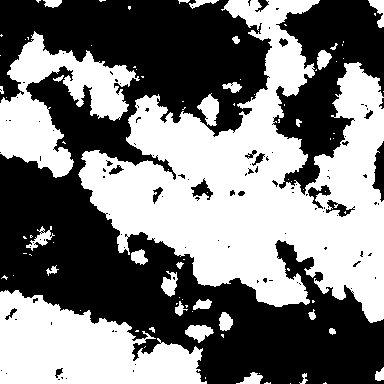

In [102]:
cv2_imshow(train_data[n][1])

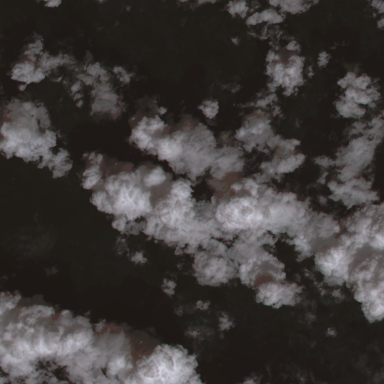

In [103]:
cv2_imshow(train_data[n][0])

In [23]:
def fix_contrast(image):
    minimumColor = np.amin(image)
    maximumColor = np.amax(image)
#     avg = (minimumColor - maximumColor)/2
    avg = np.mean(image) #second attempt
    colorDownMatrix = image < avg # also tried
    colorUpMatrix = image >= avg 
#     colorUpMatrix = image > avg * 1.5
#     colorDownMatrix = image < avg* 1.5
    image = image - minimumColor*colorDownMatrix
    image = image + maximumColor*colorUpMatrix
    lessThen0 = image<0
    moreThen255 = image>255
    image[lessThen0] = 0
    image[moreThen255] = 255
    return image 

#### Build the model 💻
For this task we will use U-Net model
![](https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png)


To build the model we will create Double convs objects and try to connect them so as to build the final model

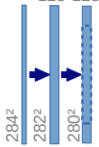

In [74]:
# Double Conv
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [107]:
# Build the Unet Model
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[ 64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        skip_connections = []
        x = x.resize_(1,3,384,384)
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [108]:
#Instantiate the model
unet = UNET()

### Train the model

In [110]:
n = random.randint(0, len(train_data))

In [84]:
loss_fn = nn.L1Loss()
optimizer = Adagrad(unet.parameters(), lr=0.001, weight_decay=0.0001)

In [111]:
learning_rate = 0.001
optimizer = Adam(unet.parameters(), lr=learning_rate, weight_decay=0.0001)
n_epochs = 40
loss = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet.to(device)
l = []
for epoch in range(n_epochs):
  running_loss = 0.0
  running_acc = 0.0
  for (imgs, labels) in DataLoader(train_data,batch_size=18,shuffle=True):
    batch_size = imgs.shape[0]
    out = []
    for j in range(batch_size):
      labels = labels/255
      imgs = imgs.to("cuda:0")
      labels = labels.to("cuda:0")
      outputs = unet(imgs[j])
      running_acc += (fix_contrast(outputs.cpu().detach().numpy())==labels.cpu().detach().numpy()).sum().item()
      out.append(outputs)
    pic = torch.stack(out)
    del out
    loss = loss_fn(pic.reshape(18,384,384).float(), labels.float())
    del pic
    del labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss
  l.append(float(running_loss))
  print("Epoch: %d, Loss: %f, Accuracy: %d " % (epoch + 1, float(running_loss), float(running_acc/384**2)))
  plot_image(train_data[n])

RuntimeError: ignored

<Figure size 720x720 with 0 Axes>

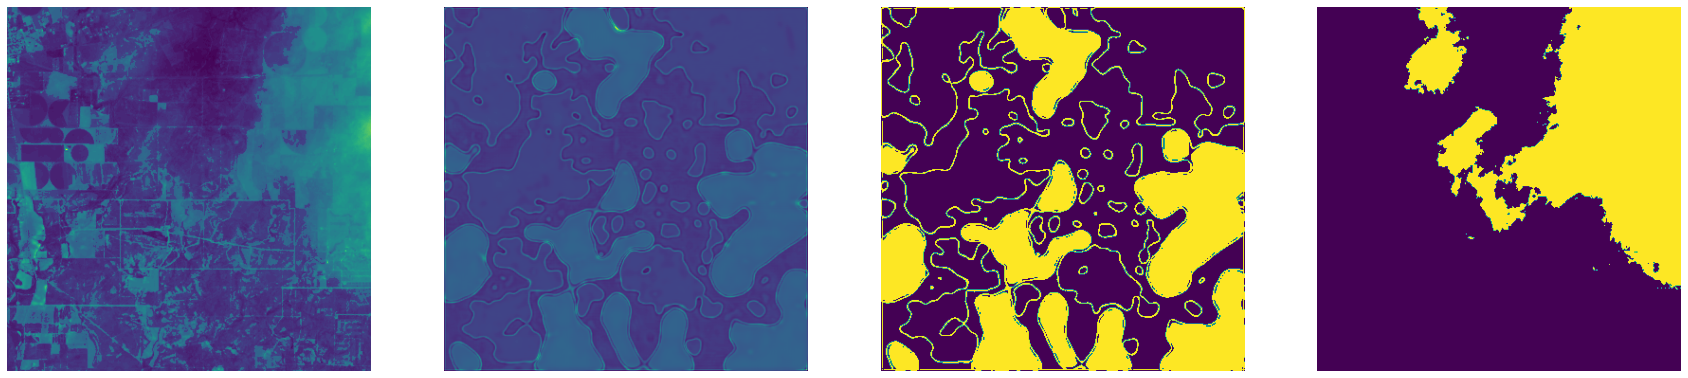

<Figure size 720x720 with 0 Axes>

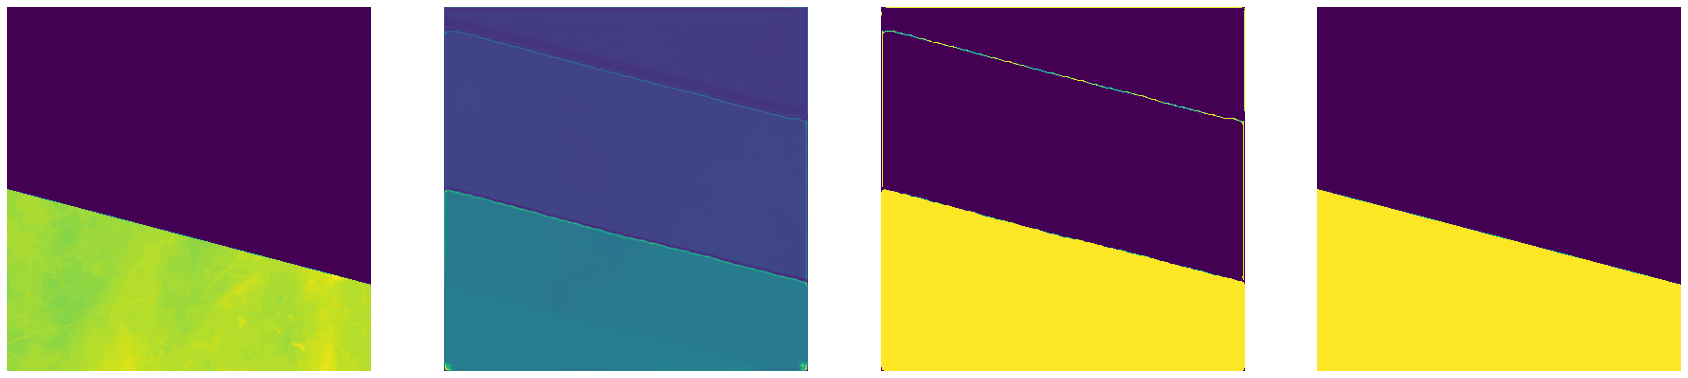

<Figure size 720x720 with 0 Axes>

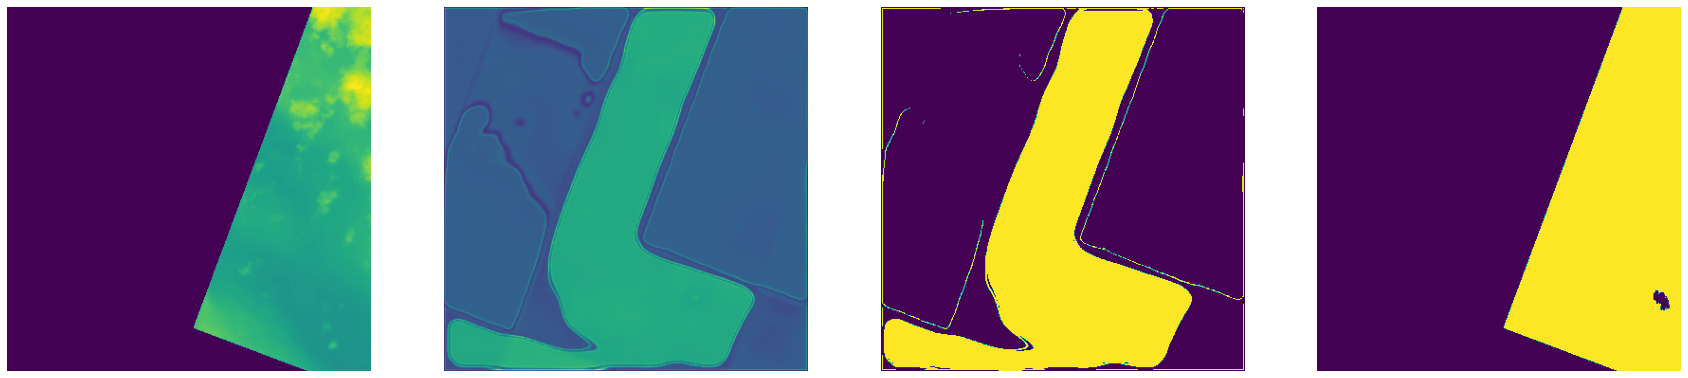

<Figure size 720x720 with 0 Axes>

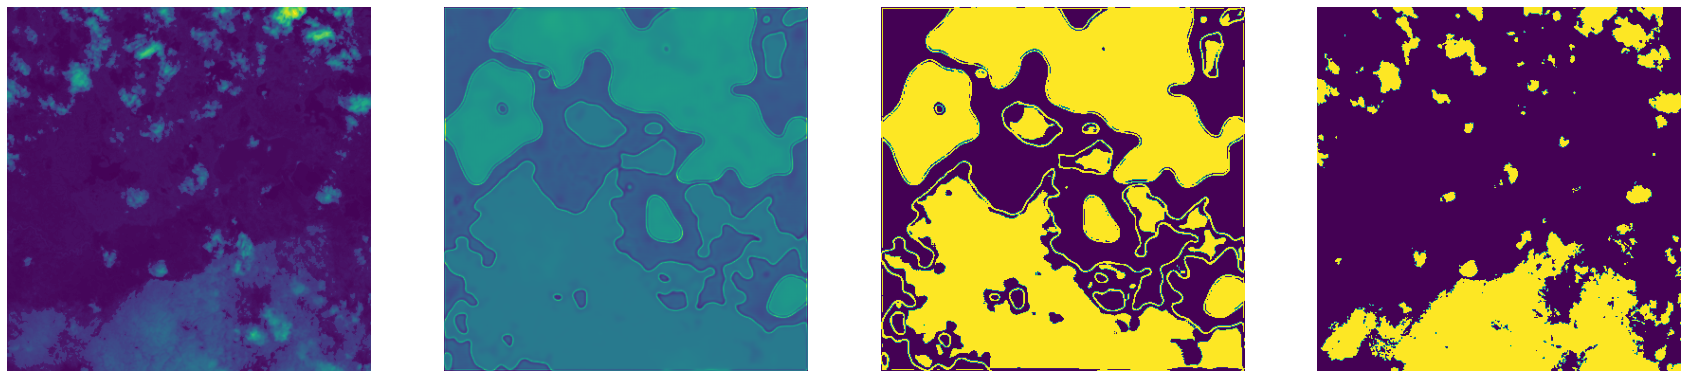

<Figure size 720x720 with 0 Axes>

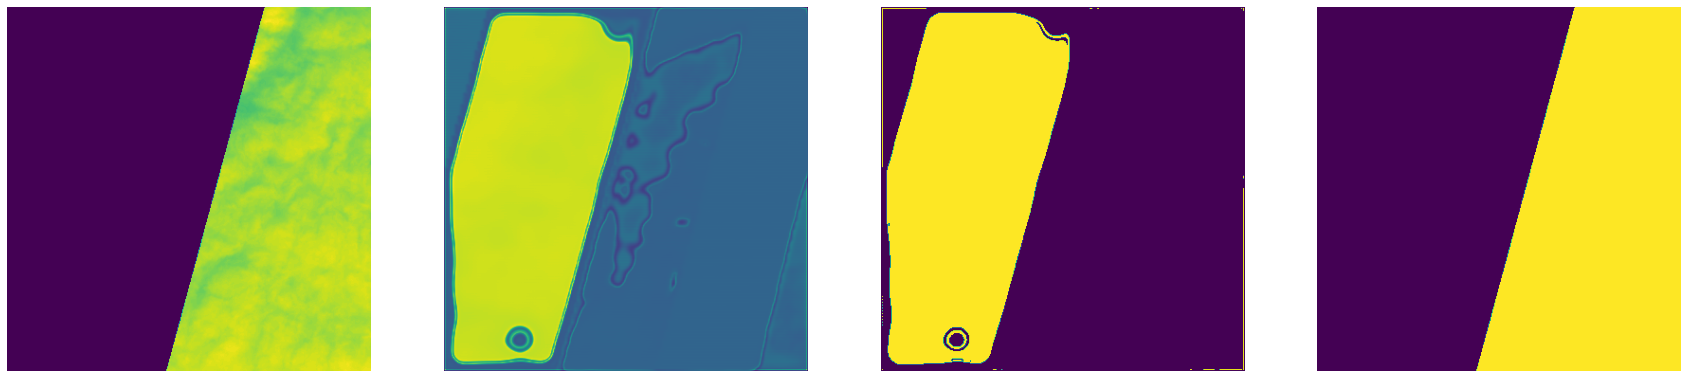

<Figure size 720x720 with 0 Axes>

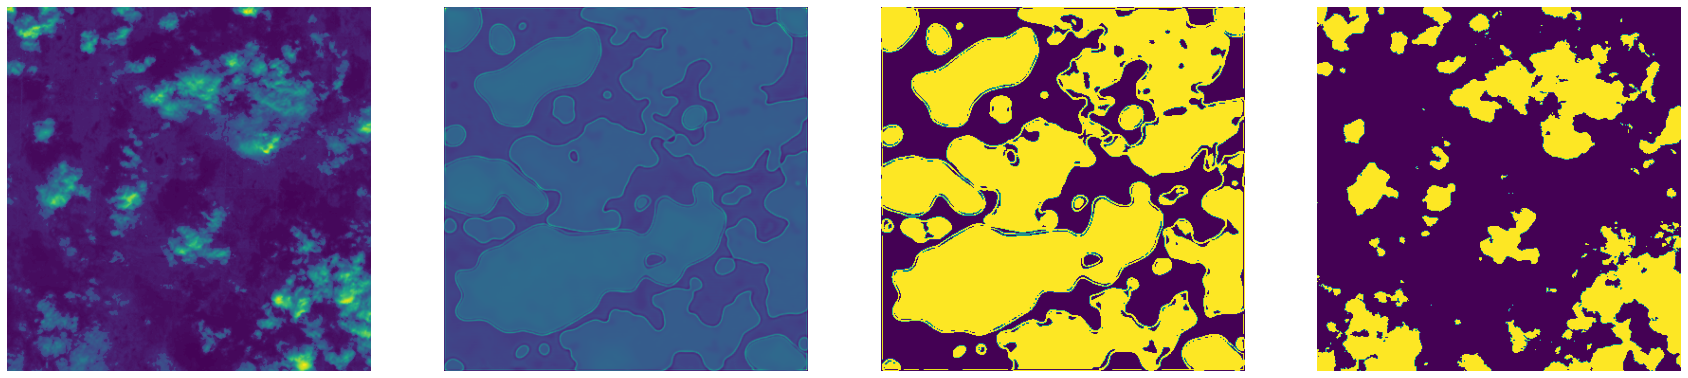

<Figure size 720x720 with 0 Axes>

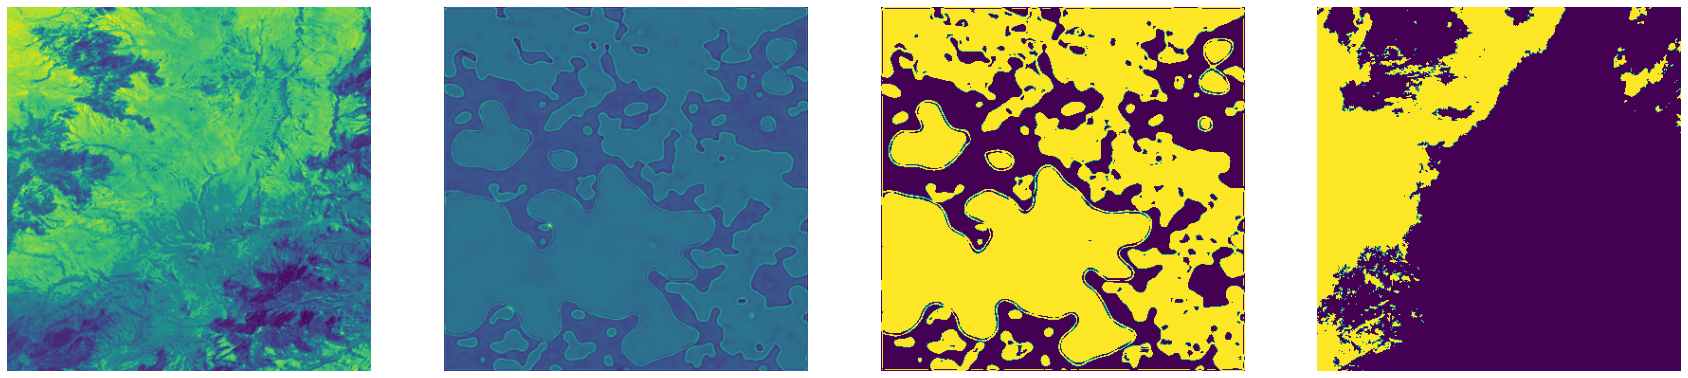

<Figure size 720x720 with 0 Axes>

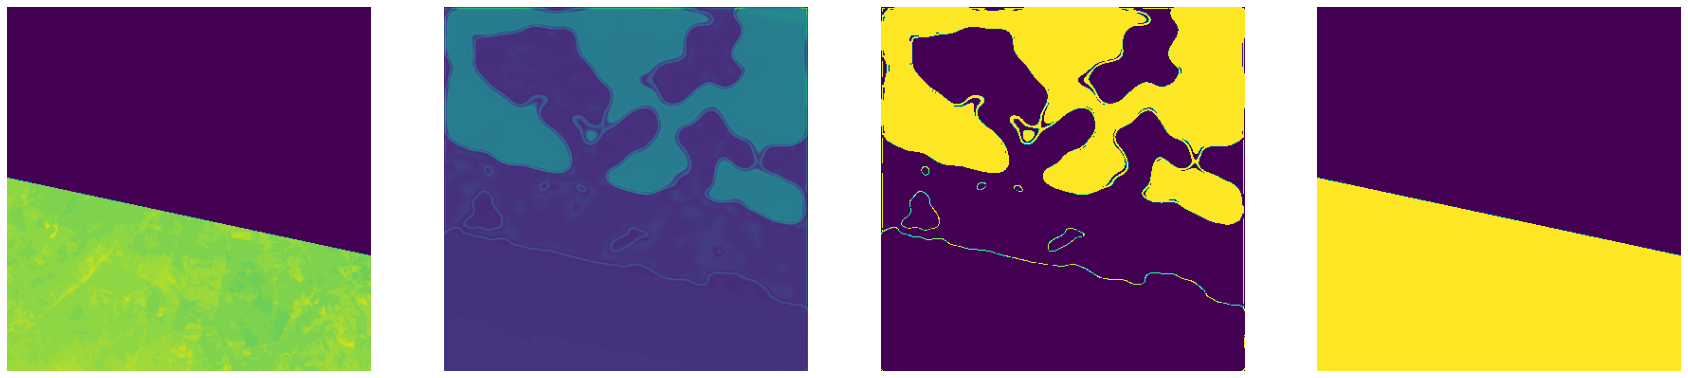

<Figure size 720x720 with 0 Axes>

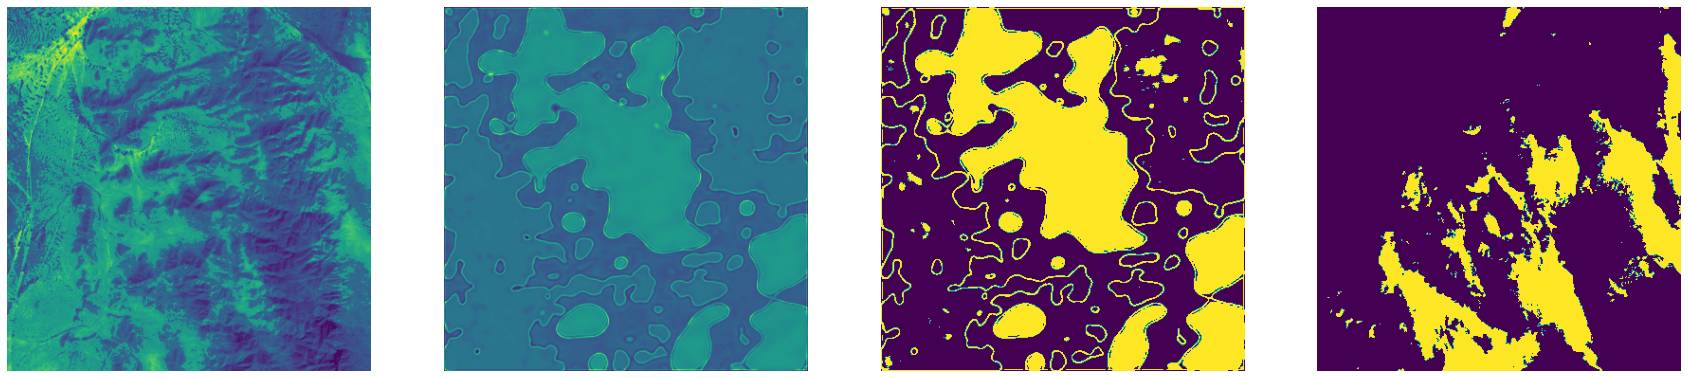

<Figure size 720x720 with 0 Axes>

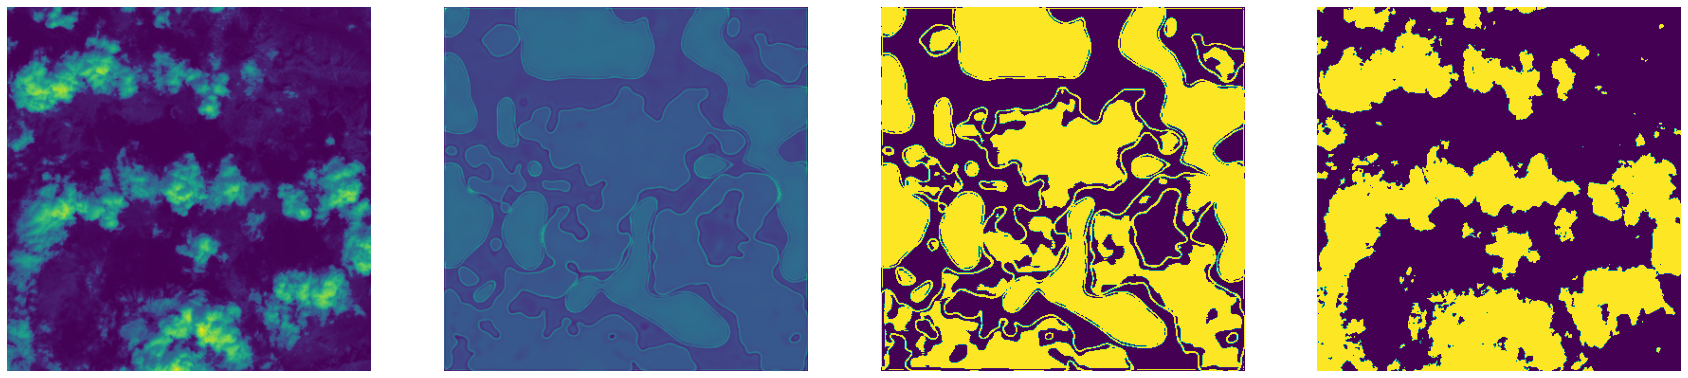

In [106]:
for i in range(10):
    n = random.randint(0, len(train_data))
    plot_image(train_data[n])

In [ ]:
def plot_image(x):
    tensor = torch.from_numpy(x[0])
    tensor = tensor.cuda()
    out = unet(tensor)
    tensor2 = torch.from_numpy(x[1])
    tensor2 = tensor2.cuda()
    tensor_cv2 = tensor.reshape(384,384,1).cpu().detach().numpy()
    plt.figure(figsize=(10,10))
    out_cv2 = out.reshape(384,384).cpu().detach().numpy()
        # out_cv2 = exposure.adjust_gamma(out_cv2, 2)
        # plt.imshow(out_cv2)
        # out_cv2 = filters.sobel(out_cv2)
    val1 = filters.threshold_isodata(out_cv2)
    val2 = filters.threshold_mean(out_cv2)
    val3 = filters.threshold_li(out_cv2)
    val4 = filters.threshold_yen(out_cv2)
    val5 = filters.threshold_otsu(out_cv2)

    pic_cv2 = out_cv2>=val1

    lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_figheight(30)
    fig.set_figwidth(30)
    ax1.axis('off')
    ax1.imshow(tensor_cv2)
    ax2.axis('off')
    ax2.imshow(out_cv2)
    ax3.axis('off')
    ax3.imshow(pic_cv2)
    ax4.axis('off')
    ax4.imshow(lab_cv2)
    plt.show()

In [ ]:
plt.figure(figsize=(10,10))
tensor_cv2 = tensor.reshape(384,384,1).cpu().detach().numpy()
plt.imshow(tensor_cv2)


plt.figure(figsize=(10,10))
out_cv2 = out.reshape(384,384).cpu().detach().numpy()
# out_cv2 = exposure.adjust_gamma(out_cv2, 2)
# plt.imshow(out_cv2)
# out_cv2 = filters.sobel(out_cv2)
# val1 = filters.threshold_isodata(out_cv2)
val2 = filters.threshold_mean(out_cv2)
val3 = filters.threshold_li(out_cv2)
val4 = filters.threshold_li(out_cv2)
val5 = filters.threshold_otsu(out_cv2)

pic_cv2 = (out_cv2>val2)*0.15 + (out_cv2>val3)*0.15 + (out_cv2>val4)*0.3 + (out_cv2>val5)*0.4

plt.figure(figsize=(10,10))
plt.imshow(pic_cv2>.2)

plt.figure(figsize=(10,10))
lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()
plt.imshow(lab_cv2)
plt.show()

In [ ]:
a = []
for i in range(100000000000000000000):
  a.append(i)

In [ ]:
((np.abs(((pic_cv2>=0.2))*255).all()- lab_cv2).sum())/384**2

Reminder : not cloud 1, cloud 0

In [ ]:
plt.imshow(pic_cv2>0.6)

In [ ]:
s = torch.randint(1,10,(2,3))
s, s.sum().numpy()/255**2

In [ ]:
!pip install ipywidgets

In [ ]:
from ipywidgets import interact

def f(x):
    return x
interact(f, x=10)

In [ ]:
import ipywidgets as widgets

# For explicitly displaying widgets
from IPython.display import display

# Just need these for the demo purposes here
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Create an simple IntSlider widget
demo_IntSlider_1 = widgets.IntSlider(
    min=1,                      # The minimum value
    max=100,                    # The maximum value
    description='Int Slider 1', # Label
    value=53,                   # Default value
)

# Display the widget
display(demo_IntSlider_1)

In [ ]:
torch.save(unet, 'model.pth')

In [ ]:
unet = torch.load('model.pth')

In [ ]:
from IPython.display import FileLink
FileLink("model.pth")

/kaggle/working/model.pth